In [1]:
import torch 
import numpy as np

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **NEURAL NETWORK**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, layer_size):
      super(PINN, self).__init__()

      self.fc1 = nn.Linear(input_dim, layer_size)
      self.fc2 = nn.Linear(layer_size, layer_size)
      self.fc3 = nn.Linear(layer_size, layer_size)
      self.fc4 = nn.Linear(layer_size, output_dim)



    def forward(self, input_grid, input_0, input_lb, input_ub):
      _, f_predict = self.forward_it(input_grid.float())
      predict_0, _ = self.forward_it(input_0.float())
      predict_lb, _ = self.forward_it(input_lb.float())
      ub_predict, _ = self.forward_it(input_ub.float())
      return f_predict, predict_0, predict_lb, ub_predict



    def forward_it(self, X):
      batch_size = X.shape[0]
      x, t = X[:, :1], X[:, 1:]
      x.requires_grad_(True)
      t.requires_grad_(True)

      s = nn.Tanh()(self.fc1(torch.cat((x, t), 1)))
      s = nn.Tanh()(self.fc2(s))
      s = nn.Tanh()(self.fc3(s))
      u = self.fc4(s)
      u_t = autograd.grad(u, t, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
      u_x = autograd.grad(u, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]
      u_xx = autograd.grad(u_x, x, torch.ones((batch_size, 1)).to(device), create_graph=True)[0]

      f = u_t + u * u_x - (0.01 / np.pi) * u_xx

      return u, f
    


    def predict(self, X):
      s = nn.Tanh()(self.fc1(X))
      s = nn.Tanh()(self.fc2(s))
      s = nn.Tanh()(self.fc3(s))
      u = self.fc4(s)
      return u

# **OPTIMIZATION**

In [6]:
from torch.optim import LBFGS
from time import time
from tqdm.notebook import tqdm as tqdm

In [7]:
class Train():
    def __init__(self, network, grid_input, input_0, target_0, l_boundary_input, l_boundary_target, u_boundary_input, u_boundary_target):
        self.net = network

        self.lbfgs_optim = LBFGS(self.net.parameters(), lr=1, max_iter=50000, line_search_fn='strong_wolfe')

        self.train_input_grid = grid_input 
        self.train_input_0, self.train_target_0 = input_0, target_0
        self.train_input_lb, self.train_target_lb = l_boundary_input, l_boundary_target
        self.train_input_ub, self.train_target_ub = u_boundary_input, u_boundary_target


    def train(self):
        start_time = time()
        
        self.train_iteration(self.train_input_grid, self.train_input_0, self.train_target_0, self.train_input_lb, self.train_target_lb, self.train_input_ub, self.train_target_ub)
        
        end_time = time()
        print('Time:', end_time - start_time)     



    def train_iteration(self, input_grid, input_0, target_0, input_lb, target_lb, input_ub, target_ub):
    
        def closure():
            if torch.is_grad_enabled():
                self.lbfgs_optim.zero_grad()
            f_predict, predict_0, predict_lb, predict_ub = self.net(input_grid, input_0, input_lb, input_ub)
            loss = self.loss_function(predict_0, target_0, predict_lb, target_lb, predict_ub, target_ub, f_predict)
            if loss.requires_grad:
                loss.backward()
            return loss
        self.lbfgs_optim.step(closure)


    def loss_function(self, predict_0, target_0, predict_lb, target_lb, predict_ub, target_ub, f_predict):
        loss_fn = nn.MSELoss()
        loss = loss_fn(predict_0.double(), target_0.double()) + loss_fn(predict_lb.double(), target_lb.double()) + \
            loss_fn(predict_ub.double(), target_ub.double()) + loss_fn(f_predict.double(), torch.zeros((f_predict.shape[0], 1)).double().to(device))
        return loss


# **MAIN**


## DATA PREPERATION

In [8]:
import scipy.io

FUNCTIONS FOR DATA MANAGEMENT

In [9]:
def create_passable_data(x, t, u=None):
  N_x = x.shape[0]
  N_t = t.shape[0]
  passable_input = []
  passable_target = []

  for nt in range(N_t):
    for nx in range(N_x):
      _t = t[nt, 0]
      _x = x[nx, 0]
      _passable_input = np.array([_x, _t])[np.newaxis]
      passable_input.append(_passable_input)
      if u is not None:
        _u = u[nt, nx]
        _passable_target = np.array(_u)
        passable_target.append(_passable_target)
  
  passable_input = np.array(passable_input)
  passable_input = torch.tensor(passable_input).view(N_t * N_x, 2)

  if u is not None:
    passable_target = np.array(passable_target)
    passable_target = torch.tensor(passable_target).view(N_t * N_x, 1)

  return passable_input, passable_target

COLLECTING THE DATA

In [10]:
data = scipy.io.loadmat('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/appendix/Data/burgers_shock.mat')

t_data = data['t']  # SHAPE (100, 1)
x_data = data['x']  # SHAPE (256,1)
u_data = np.real(data['usol']).T  # SHAPE (100, 256)

lb = np.array([-1, 0.0]) # (spacial lower bound, time lower bound)
ub = np.array([1, 1]) # (spacial upper bound, time upper bound)

In [11]:
grid_input, grid_target = create_passable_data(x_data, t_data, u_data)
print('GRID:', grid_input.shape)
l_boundary_input, l_boundary_target = create_passable_data(lb[0][np.newaxis][np.newaxis], t_data, u_data)
print('L BOUNDARY:', l_boundary_input.shape, l_boundary_target.shape)
u_boundary_input, u_boundary_target = create_passable_data(ub[0][np.newaxis][np.newaxis], t_data, u_data)
print('U BOUNDARY:', u_boundary_input.shape, u_boundary_target.shape)
input_0, target_0 = create_passable_data(x_data, lb[1][np.newaxis][np.newaxis], u_data)
print('INIT', input_0.shape, target_0.shape)

GRID: torch.Size([25600, 2])
L BOUNDARY: torch.Size([100, 2]) torch.Size([100, 1])
U BOUNDARY: torch.Size([100, 2]) torch.Size([100, 1])
INIT torch.Size([256, 2]) torch.Size([256, 1])


In [12]:
idx = np.arange(u_boundary_input.shape[0])
temp = np.random.permutation(idx)[:50]
u_boundary_input, u_boundary_target = u_boundary_input[temp, :].view(-1, 2), u_boundary_target[temp, :].view(-1, 1)
temp = np.random.permutation(idx)[:50]
l_boundary_input, l_boundary_target = l_boundary_input[temp, :].view(-1, 2), l_boundary_target[temp, :].view(-1, 1)

idx = np.arange(input_0.shape[0])
temp = np.random.permutation(idx)[:50]
input_0, target_0 = input_0[temp, :].view(-1, 2), target_0[temp, :].view(-1, 1)

In [13]:
print('L BOUNDARY:', l_boundary_input.shape, l_boundary_target.shape)
print('U BOUNDARY:', u_boundary_input.shape, u_boundary_target.shape)
print('INITIAL BOUNDARY:', input_0.shape, target_0.shape)

L BOUNDARY: torch.Size([50, 2]) torch.Size([50, 1])
U BOUNDARY: torch.Size([50, 2]) torch.Size([50, 1])
INITIAL BOUNDARY: torch.Size([50, 2]) torch.Size([50, 1])


## TRAINING

INITIALIZE NETWORK

In [14]:
input_dim, output_dim, layer_size = 2, 1, 100
net = PINN(input_dim, output_dim, layer_size).to(device)

TRAINING NETWORK

In [15]:
train = Train(net, grid_input.to(device), input_0.to(device), target_0.to(device), l_boundary_input.to(device), l_boundary_target.to(device), u_boundary_input.to(device), u_boundary_target.to(device))

In [16]:
train.train()

Time: 843.3568167686462


## PLOTTING

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

PLOTTIG FUNCTIONS

In [18]:
def plot_grid(u_plot, t_data, X_grid, T_grid, string_title, lb_input=None, ub_input=None, input_0=None, t_index_low=None, t_index_mid=None, t_index_high=None):
    fig = plt.subplots(figsize=(8, 4))
    plt.contourf(T_grid, X_grid, u_plot, 1000, cmap=plt.get_cmap('Spectral'))
    plt.colorbar()
    plt.ylabel(r'$x$')
    plt.xlabel(r'$t$')
    plt.title(string_title, fontsize = 15) 

    try:
        fig[1].set_ylim(x_data.min(), x_data.max())
        fig[1].plot(lb_input[:,1], lb_input[:,0], 'kx', label = 'Data (%d points)' % (lb_input.shape[0]), markersize = 6, clip_on = False)
        fig[1].plot(ub_input[:,1], ub_input[:,0], 'kx', label = 'Data (%d points)' % (ub_input.shape[0]), markersize = 6, clip_on = False)
        fig[1].plot(input_0[:,1], input_0[:,0], 'kx', label = 'Data (%d points)' % (input_0.shape[0]), markersize = 6, clip_on = False)
        
        
        line = np.linspace(x_data.min(), x_data.max(), 2)[:,None]
        fig[1].plot(t_data[t_index_low]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_mid]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_high]*np.ones((2,1)), line, 'k--', linewidth = 1) 
    except Exception:
        pass    
    
    plt.show()
    plt.draw()
    #fig[0].savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Burgers_Continuous_Inference/' + string_title.format(1000), bbox_inches='tight')
    plt.close()

def plot_time_step(x_data, t_data, u_data, u_pred, t_index, x_lb, x_ub, y_lb, y_ub):
    fig = plt.subplots(figsize=(2.6,2.6))
    fig[1].plot(x_data, u_data[t_index,:], 'b-', linewidth = 2, label = 'Exact')       
    fig[1].plot(x_data, u_pred[t_index,:], 'r--', linewidth = 2, label = 'Prediction')
    fig[1].set_xlabel('$x$')
    fig[1].set_ylabel('$u(t,x)$')  
    title = '$t = %.2f' % t_data[t_index].item() + '$'
    fig[1].set_title(title, fontsize = 15)
    fig[1].set_xlim([x_lb, x_ub])
    fig[1].set_ylim([y_lb, y_ub])
    fig[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)
    plt.show()
    #fig[1].figure.savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/target_v_pred_t%.2f' % t_data[t_index].item() + '.png', bbox_inches = 'tight')

PLOTTING TARGET DATA

Locator attempting to generate 1001 ticks ([-1.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


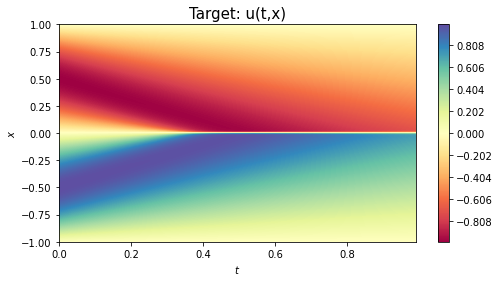

In [19]:
X, T = np.meshgrid(x_data, t_data)
u_target = u_data
plot_grid(u_target, t_data, X, T, 'Target: u(t,x)')

PLOTTING PREDICTED DATA

In [20]:
u_predict = net.predict(grid_input.to(device).float())
u_plot = u_predict.cpu().view(X.shape).detach().numpy()

snapshot_index_low=int(t_data.shape[0]/5)
snapshot_index_middle=int(t_data.shape[0]/2)
snapshot_index_high=int(4*t_data.shape[0]/5)

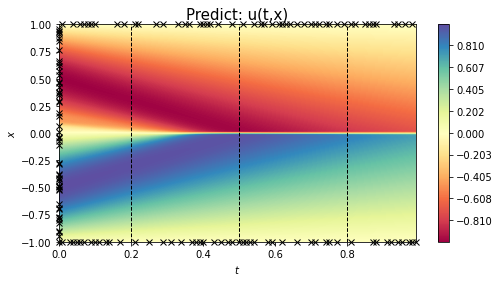

In [21]:
plot_grid(u_plot, t_data, X, T, 'Predict: u(t,x)', l_boundary_input, u_boundary_input, input_0, snapshot_index_low, snapshot_index_middle, snapshot_index_high)

TARGET VS PREDICT AT SPECIFIC TIME STEPS


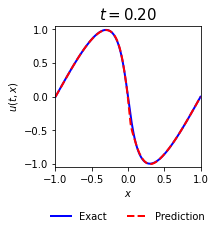

In [22]:
plot_time_step(x_data, t_data, u_target, u_plot, snapshot_index_low, x_data.min(), x_data.max(), u_target.min()*1.05, u_target.max()*1.05)

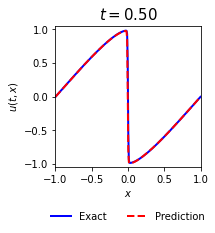

In [23]:
plot_time_step(x_data, t_data, u_target, u_plot, snapshot_index_middle, x_data.min(), x_data.max(), u_target.min()*1.05, u_target.max()*1.05)

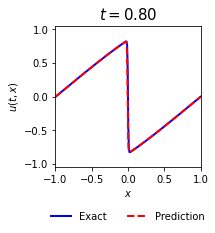

In [24]:
plot_time_step(x_data, t_data, u_target, u_plot, snapshot_index_high, x_data.min(), x_data.max(), u_target.min()*1.05, u_target.max()*1.05)

##ERROR


In [25]:
criterion = nn.MSELoss()
Error = criterion ( u_predict.cpu(), grid_target)

print('L2 Norm Error:', Error.item())

Error_relative = Error / (torch.mean(torch.abs(grid_target)))
print('Relative L2 Norm Error:', Error_relative.item())

L2 Norm Error: 0.0008663450177565668
Relative L2 Norm Error: 0.0016131431577138767
